In [1]:
# this is where we look at relevant ROIs from neurosynth to calculate and 
# visualize spatial activation pattern reliabiltiy within subjects across encounters

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# helper functions:
def build_contrast_map_path(base_dir, level, subject, session, task, contrast_name):
    """Build the file path for a contrast map."""
    filename = f'{subject}_{session}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
    
    # NOTE: as of 7/6/25 for sub 10 in flanker the format is different: sub-s10_ses-01_run-1_task-flanker_contrast-incongruent-congruent_rtmodel-rt_centered_stat-effect-size.nii.gz
    if (subject == 'sub-s10' and task == 'flanker'):
        filename = f'{subject}_{session}_run-1_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
        
    return os.path.join(base_dir, level, subject, task, 'indiv_contrasts', filename)

def is_valid_contrast_map(img_path):
    """Check if a contrast map has sufficient variance and no NaN values."""
    try:
        img = nib.load(img_path)
        data = img.get_fdata()
        return np.std(data) > 1e-10 and not np.isnan(data).any()
    except Exception as e:
        print(f"Error validating {img_path}: {e}")
        return False
        
def clean_z_map_data(z_map, task, contrast_name, encounter):
    """Clean z-map data by handling NaN and infinity values."""
    data = z_map.get_fdata()
    if np.isnan(data).any() or np.isinf(data).any():
        data = np.nan_to_num(data)
        z_map = nib.Nifti1Image(data, z_map.affine, z_map.header)
        print(f"Warning: Fixed NaN/Inf values in {task}:{contrast_name}:encounter-{encounter+1}")
    return z_map

def save_rsm(rsm_results, filename):
    """
    Simple save function
    
    Parameters:
        rsm_results: RSM results dictionary
        filename: filename to save (will add .pkl automatically)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(rsm_results, f)
    
    file_size = os.path.getsize(filename) / (1024 * 1024)
    print(f"Saved to {filename} ({file_size:.1f} MB)")

def load_rsm(filename):
    """
    Simple load function
    
    Parameters:
        filename: filename to load
    
    Returns:
        rsm_results: Loaded RSM dictionary
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'rb') as f:
        rsm_results = pickle.load(f)
    
    print(f"Loaded from {filename}")
    return rsm_results

def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")

In [3]:
# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack", 'task-baseline']
requested_task_contrasts['flanker'] = ["incongruent-congruent",'task-baseline']
requested_task_contrasts['directedForgetting'] = ["neg-con",'task-baseline']
requested_task_contrasts['goNogo'] = ["nogo_success-go",'task-baseline']
requested_task_contrasts['shapeMatching'] = ["main_vars",'task-baseline']
requested_task_contrasts['stopSignal'] = ["stop_failure-go",'task-baseline']
requested_task_contrasts['stopSignal'] = ["stop_success-go",'task-baseline']
requested_task_contrasts['cuedTS'] = ["task_switch_cost",'task-baseline']
requested_task_contrasts['spatialTS'] = ["task_switch_cost",'task-baseline']

# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

loading in each subject's contrast map per session:

In [4]:
# where the first level contrast maps are stored
BASE_DIR = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_20250402/derivatives/'
LEVEL = 'output_lev1_mni'
# subjects in the discovery sample
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']
SESSIONS = ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09','ses-10']

# number of encounters each subject has with a task
max_num_encounters = 5

In [5]:
# arrange each subjects maps by which encounter num it is
all_contrast_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
encounter_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for task in TASKS:
    for contrast_name in CONTRASTS[task]:
        for subject in SUBJECTS:
            overall_encounter_count = 0
            
            for session in SESSIONS:
                contrast_map_path = build_contrast_map_path(BASE_DIR, LEVEL, subject, session, task, contrast_name)
                
                if os.path.exists(contrast_map_path):
                    all_contrast_maps[task][contrast_name][subject].append(contrast_map_path)
                    encounter_maps[task][contrast_name][subject][overall_encounter_count] = contrast_map_path
                    overall_encounter_count += 1

first_level_session_maps = all_contrast_maps
first_level_encounter_maps = encounter_maps

In [6]:
# relevant loading functions taken from 3_create_RSMs_first_level
# function to gather maps of a certain task/contrast from first_level_encounter_maps
def gather_tc_maps(req_tasks,req_contrasts,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS):
    '''
    Get a list of loaded niftis for specific task/contrast/encounter combinations of first level maps 
    
    Parameters
        req_tasks: list of tasks as strings (all tasks have to be from the TASKS dict)
        req_contrasts: list of contrasts as strings (all tasks have to be from the CONTRASTS dict)
        all_maps: [task][contrast_name][subject][overall_encounter_count] -> one map each (here it is in a filepath format)
        req_encounters: list of encounter numbers that are requested (default is all 5)
        req_subjects: list of subject id strings that are requested (default is all in SUBJECTS)
    Return
        specified_maps: list of loaded nifti files that fit the requested task, contrast, and encounter (this returns this for all subjects)
        specified_descriptors: list of descriptions of each file (i.e. titles)
        data_title: informative title for the RSM that will later be created
    
    '''
    specified_maps = []
    specified_descriptors = []
    max_num_encounters = 5

    if (len(req_tasks) == 0) or (len(req_contrasts) == 0):
        return [], [], ''

    for task in req_tasks:
        if task not in TASKS:
            print(f"task {task} not in task masterlist")
            continue
    
        for contrast in req_contrasts:
            if contrast not in CONTRASTS[task]: # make sure this contrast exists in the given task
                print(f"skipped for contrast {contrast} and task {task}")
                continue
                
            for subject in req_subjects:
                if subject not in SUBJECTS:
                    print(f"subject: {subject} is not in this dataset, so skipped")
                    continue
                    
                for encounter in req_encounters:
                    if encounter < 0 or encounter >= max_num_encounters:
                        continue

                    descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                            
                    if task in all_maps.keys():
                        if contrast in all_maps[task].keys():
                            if subject in all_maps[task][contrast].keys():
                                if encounter in all_maps[task][contrast][subject].keys():

                                    map_data = all_maps[task][contrast][subject][encounter]
                                    
                                    # Check if file is already loaded
                                    if isinstance(map_data, str):
                                        # map_data is a file path, need to load it
                                        try:
                                            if os.path.exists(map_data):
                                                loaded_map = nib.load(map_data)
                                                specified_maps.append(loaded_map)
                                                specified_descriptors.append(descriptor_name)
                                            else:
                                                print(f"File not found: {map_data}")
                                                failed_loads.append((descriptor_name, "File not found"))
                                        except Exception as e:
                                            print(f"Error loading {map_data}: {str(e)}")
                                    else:
                                        print(f"Unexpected data type for {descriptor_name}: {type(map_data)}")
                                        
                                else:
                                    print(f"{task}|{contrast}|{subject}: {encounter}")
                                    continue
                            else:
                                print(f"{task}|{contrast} subject {subject}")
                                continue
                        else:
                            print(f"{task}:{contrast}")
                            continue
                    else:
                        print(f"{task}")
                        continue
    # create RSM title
    data_title = ''
    if (len(req_tasks) == 1):
        data_title += f'Task:{req_tasks[0]}|'
    else:  # more than 1 task
        data_title += 'Task:'
        for i, task in enumerate(req_tasks):
            if (i != len(req_tasks) - 1):
                data_title += f"{task},"
            else:
                data_title += f"{task}"
        data_title += '|'

    if (len(req_contrasts) == 1):
        data_title += f'Contrast:{req_contrasts[0]}'
    else:
        data_title += 'Contrast:'
        for i, contrast in enumerate(req_contrasts):
            if (i != (len(req_contrasts) - 1)):
                data_title += f"{contrast},"
            else:
                data_title += f"{contrast}"
    
    return specified_maps, specified_descriptors, data_title

In [35]:
# TODO loading in each subjects fixed effects

# go no go

In [7]:
# get the go  no go specific data paths and load them all
curr_task = "goNogo"

task_contrast_all_maps = {}
not_included = {}
print("MISSING:") # to see what maps are missing

task_contrast_all_maps[curr_task] = {}
for contrast in requested_task_contrasts[curr_task]:
    task_contrast_all_maps[curr_task][contrast] = {}
    task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
    task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
    task_contrast_all_maps[curr_task][contrast]["data_title"] = ""

    req_tasks = [curr_task]
    req_contrasts = [contrast]

    task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks,req_contrasts,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)
    

MISSING:
goNogo|nogo_success-go|sub-s19: 4
goNogo|nogo_success-go|sub-s29: 4
goNogo|nogo_success-go|sub-s43: 4
goNogo|task-baseline|sub-s19: 4
goNogo|task-baseline|sub-s29: 4
goNogo|task-baseline|sub-s43: 4


In [8]:
# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

nogo_success-go: 22 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 22 maps loaded
  Map shape: (97, 115, 97)


## neurosynth: response inhibition: right inferior frontal gyrus and pre-sma

### loading the data per subject per encounter and masking it

Data range: 0.00 to 9.15
Non-zero values range: 3.84 to 9.15


/tmp/ipykernel_3804/3438591055.py:13: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  neurosynth_mask = image.threshold_img(neurosynth_response_inhibition_map, threshold=threshold)
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/image.py:1245: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img=threshold_img(


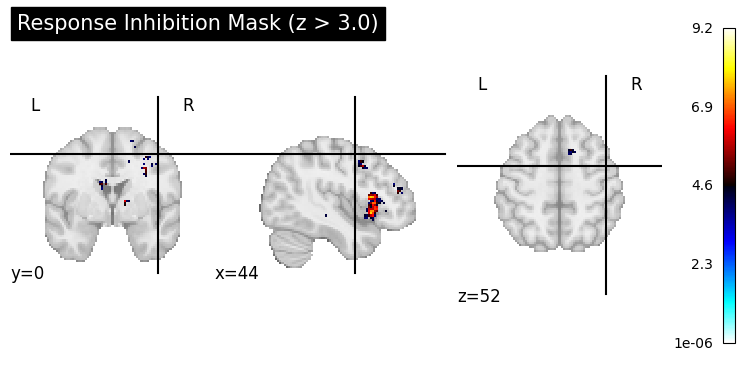

In [9]:
# load the "response inhibition" results from neurosynth
neurosynth_response_inhibition_map = nib.load('./neurosynth_rois/response_inhibition_association-test_z_FDR_0.01.nii')

# Check the data range to choose appropriate threshold
data = neurosynth_response_inhibition_map.get_fdata()
print(f"Data range: {data.min():.2f} to {data.max():.2f}")
print(f"Non-zero values range: {data[data>0].min():.2f} to {data[data>0].max():.2f}")

# pick areas of activation to use
threshold = 3.0  # pretty liberal

# create the mask + binarize it
neurosynth_mask = image.threshold_img(neurosynth_response_inhibition_map, threshold=threshold)
neurosynth_binary = image.binarize_img(neurosynth_mask)

# Visualize to see what you're getting
plotting.plot_stat_map(neurosynth_mask, 
                      title=f'Response Inhibition Mask (z > {threshold})',
                      cut_coords=[44, 0, 52])  # Should show rIFG and pre-SMA
plotting.show() # shows the right ifg in the x plot, and the pre sma in the z plot

In [10]:
# get the gonogo data for the main condition and task-baseline
inhibition_condition_maps = task_contrast_all_maps[curr_task]["nogo_success-go"]["maps_list"]
inhibition_tb_maps = task_contrast_all_maps[curr_task]["task-baseline"]["maps_list"]

# resample neurosynth map so it's same size
print("Neurosynth binary shape:", neurosynth_binary.shape)
sample_map = inhibition_condition_maps[0]
print("data shape:", sample_map.shape)
neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
print("Resampled neurosynth binary shape:", neurosynth_resampled.shape)

Neurosynth binary shape: (91, 109, 91)
data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)


/tmp/ipykernel_3804/1074279263.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [11]:
# Get the affine and shape from the resampled neurosynth map
affine = neurosynth_resampled.affine
shape = neurosynth_resampled.shape
# Create coordinate grids
coords = np.array(np.meshgrid(
    np.arange(shape[0]),
    np.arange(shape[1]), 
    np.arange(shape[2]),
    indexing='ij'))
# Convert voxel coordinates to MNI coordinates
coords_flat = coords.reshape(3, -1)
mni_coords = nib.affines.apply_affine(affine, coords_flat.T).T
x_mni = mni_coords[0].reshape(shape)
y_mni = mni_coords[1].reshape(shape) 
z_mni = mni_coords[2].reshape(shape)
# Get neurosynth mask data
mask_data = neurosynth_resampled.get_fdata()

# Create rIFG mask (right hemisphere, lateral)
rifg_data = (mask_data > 0) & (x_mni > 20) & (y_mni > 0) & (z_mni < 30)
rifg_mask = image.new_img_like(neurosynth_resampled, rifg_data.astype(np.int32))

# Create pre-SMA mask (medial, superior)  
presma_data = (mask_data > 0) & (x_mni > -10) & (x_mni < 10) & (z_mni > 40)
presma_mask = image.new_img_like(neurosynth_resampled, presma_data.astype(np.int32))

# # Create the combined mask
# combined_mask = image.math_img('img1 + img2', img1=rifg_mask, img2=presma_mask)
# Create the combined mask - use ALL of Neurosynth response inhibition network
combined_data = mask_data > 0  # All voxels in the Neurosynth map
combined_mask = image.new_img_like(neurosynth_resampled, combined_data.astype(np.int32))

# Check how many voxels are in each mask
print(f"rIFG mask: {np.sum(rifg_data)} voxels")
print(f"pre-SMA mask: {np.sum(presma_data)} voxels")
print(f"Combined mask: {np.sum(combined_mask.get_fdata() > 0)} voxels")

rIFG mask: 901 voxels
pre-SMA mask: 184 voxels
Combined mask: 2797 voxels


In [12]:
# Mask the main condition go/no-go data
rifg_values_condition = []
presma_values_condition = []
combined_values_condition = []

for map_obj in inhibition_condition_maps:
    map_array = map_obj.get_fdata()
    
    rifg_values_condition.append(map_array[rifg_data])
    presma_values_condition.append(map_array[presma_data])
    combined_values_condition.append(map_array[combined_mask.get_fdata().astype(bool)])

print(f"Extracted {len(rifg_values_condition)} values for each ROI for nogo_success-go") 

# Mask the task-baseline go/no-go data
rifg_values_tb = []
presma_values_tb = []
combined_values_tb = []

for map_obj in inhibition_tb_maps:
    map_array = map_obj.get_fdata()
    
    rifg_values_tb.append(map_array[rifg_data])
    presma_values_tb.append(map_array[presma_data])
    combined_values_tb.append(map_array[combined_mask.get_fdata().astype(bool)])

print(f"Extracted {len(rifg_values_tb)} values for each ROI in task-baseline") 

Extracted 22 values for each ROI for nogo_success-go
Extracted 22 values for each ROI in task-baseline


### visualizing how spatial activation changes over encounters in each of the regions (rIFG and pre-sma, as well as in them together)

In [13]:
def compute_rsms(specified_maps, specified_descriptors, data_title, correlation_metric='pearson'):
    '''
    RSM computation using full voxel patterns for given masked data
    
    Parameters:
        specified_maps: list of loaded nifti files or arrays
        specified_descriptors: list of descriptions for each map 
        data_title: title for the RSM
        correlation_metric: 'pearson', 'spearman', or 'cosine'
    '''
    if len(specified_maps) == 0:
        print("No maps provided for RSM computation")
        return {}, [], []
    
    n_maps = len(specified_maps)
    print(f"Computing RSM for {n_maps} maps using {correlation_metric} correlation")
    
    # Extract data arrays from maps
    map_data = []
    for map_obj in specified_maps:
        if hasattr(map_obj, 'get_fdata'):  # NIfTI object
            data = map_obj.get_fdata()
        else:  # Already an array
            data = map_obj
        map_data.append(data.flatten())  # Flatten to 1D
    
    # Compute RSM
    rsm_matrix = np.zeros((n_maps, n_maps))
    
    for i in range(n_maps):
        for j in range(n_maps):
            if i <= j:  # Only compute upper triangle (symmetric matrix)
                if correlation_metric == 'pearson':
                    corr, _ = pearsonr(map_data[i], map_data[j])
                elif correlation_metric == 'spearman':
                    corr, _ = spearmanr(map_data[i], map_data[j])
                elif correlation_metric == 'cosine':
                    dot_product = np.dot(map_data[i], map_data[j])
                    norm_i = np.linalg.norm(map_data[i])
                    norm_j = np.linalg.norm(map_data[j])
                    corr = dot_product / (norm_i * norm_j) if (norm_i * norm_j) > 0 else 0
                
                rsm_matrix[i, j] = corr
                rsm_matrix[j, i] = corr  # Fill symmetric element
    
    # Handle NaNs
    rsm_matrix = np.nan_to_num(rsm_matrix, nan=0.0)
    
    rsm_results = {
        data_title: {
            'rsm': rsm_matrix,
            'analysis_type': 'pattern',
            'full_title': data_title,
            'descriptors': specified_descriptors
        }
    }
    
    print(f"Successfully computed pattern-based RSMs for {data_title}")
    return rsm_results, specified_descriptors

In [14]:
# Get the spatial pattern rsms for the main condition and task-baseline
condition_rifg_results,_ = compute_rsms(
    rifg_values_condition,
    task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
    "nogo_success-go rifg"
)

condition_presma_results,_ = compute_rsms(
    presma_values_condition, 
    task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
    "nogo_success-go pre-sma"
)

condition_combined_results,_ = compute_rsms(
    combined_values_condition, 
    task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
    "nogo_success-go all neurosynth response inhibition"
)

tb_rifg_results,_ = compute_rsms(
    rifg_values_tb,
    task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
    "tb rifg"
)

tb_presma_results,_ = compute_rsms(
    presma_values_tb, 
    task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
    "tb pre-sma"
)

tb_combined_results,_ = compute_rsms(
    combined_values_tb, 
    task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
    "tb all neurosynth response inhibition"
)

Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for nogo_success-go rifg
Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for nogo_success-go pre-sma
Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for nogo_success-go all neurosynth response inhibition
Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for tb rifg
Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for tb pre-sma
Computing RSM for 22 maps using pearson correlation
Successfully computed pattern-based RSMs for tb all neurosynth response inhibition


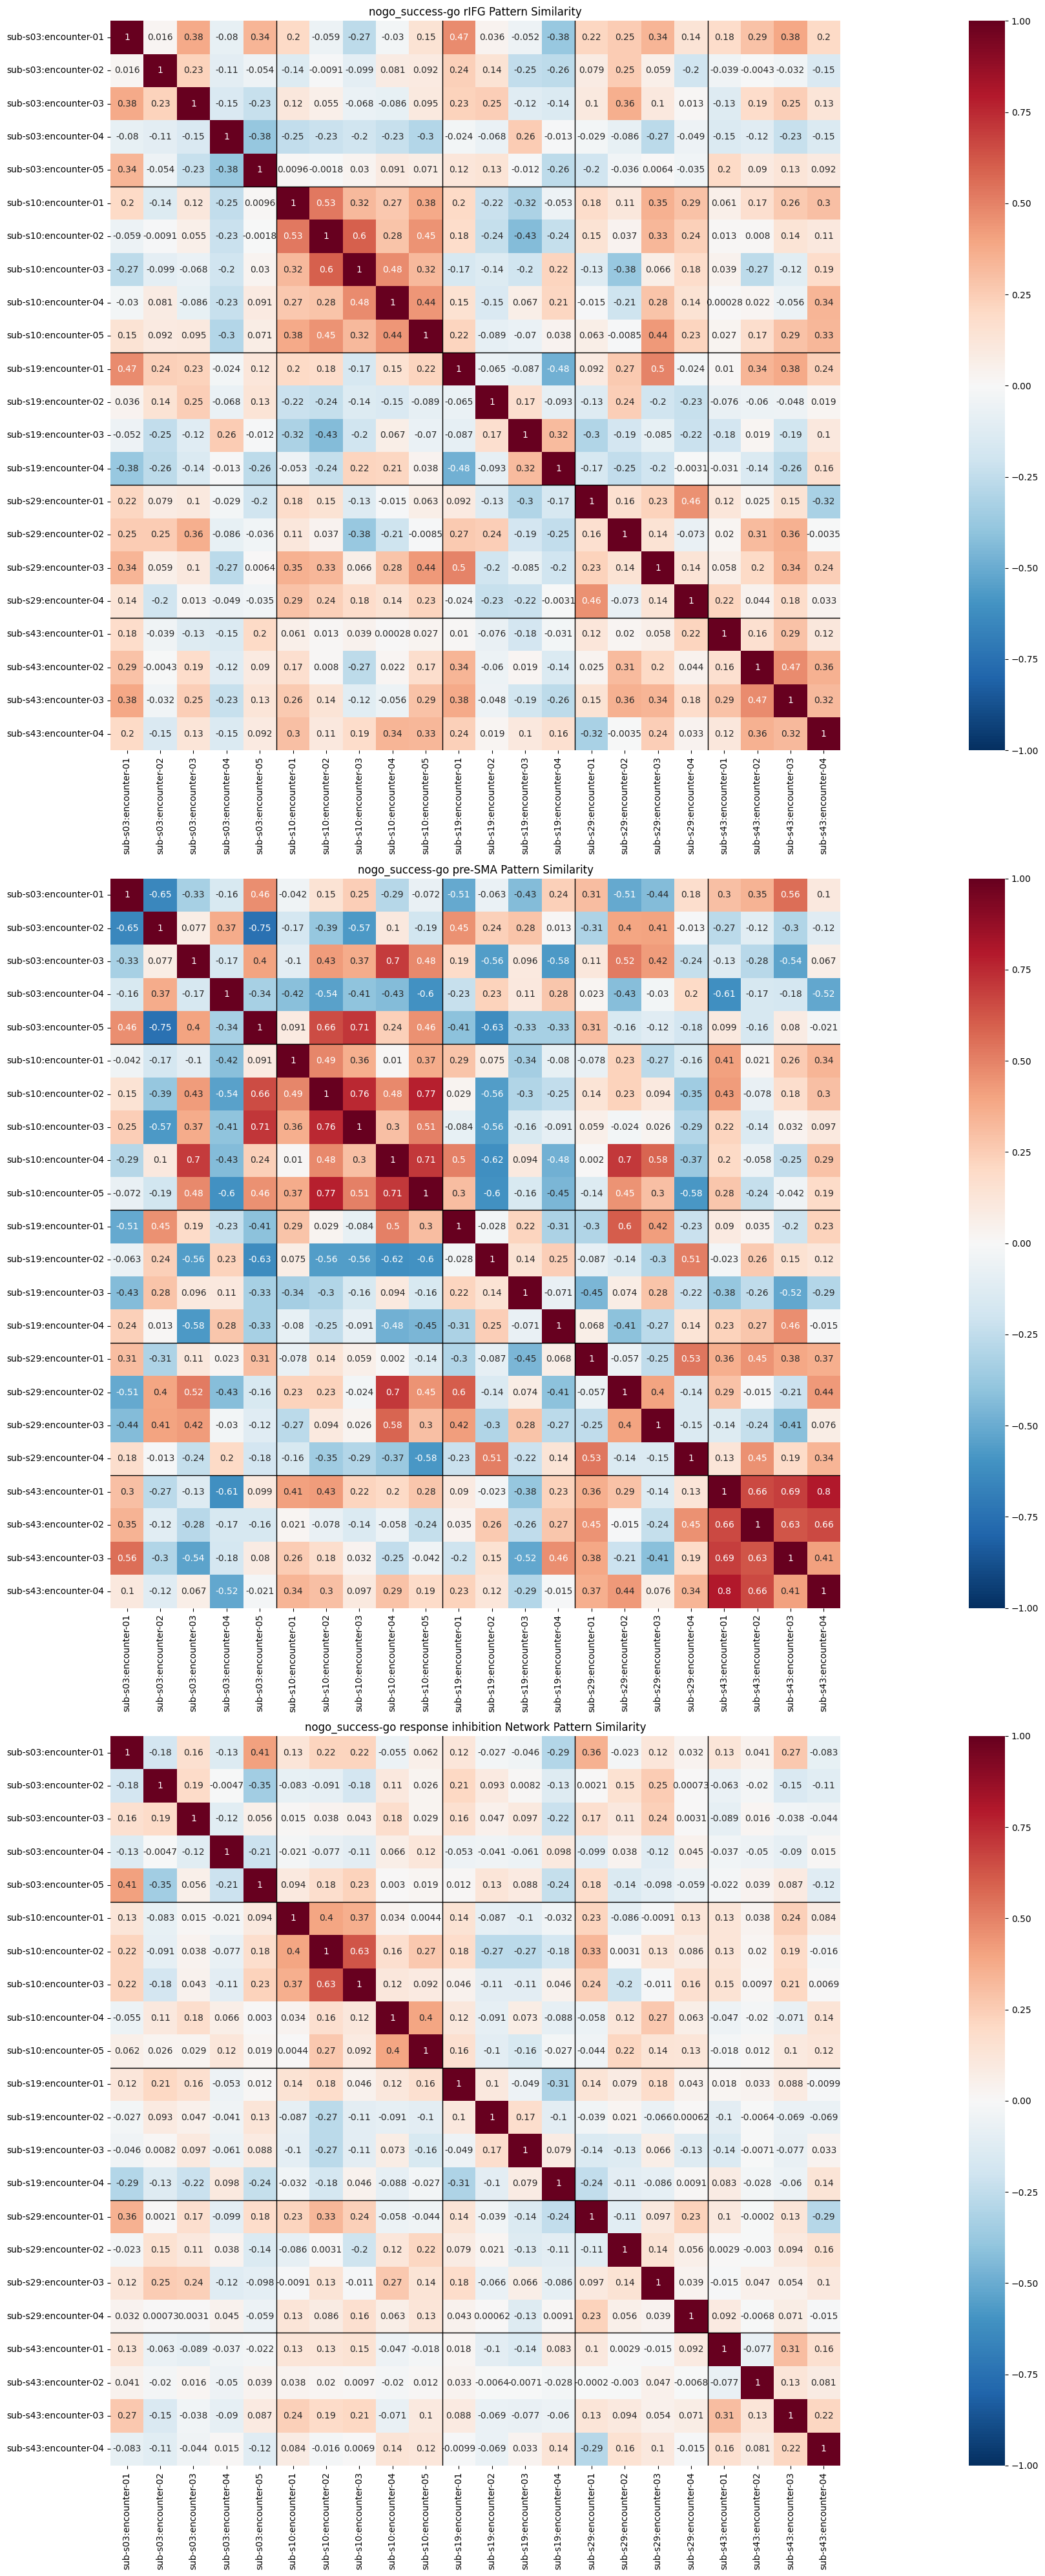

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(40, 40))

# mask upper triangle
mask_upper_tri = np.tril(np.ones_like(condition_rifg_results["nogo_success-go rifg"]['rsm'],dtype=bool),k=-1)

# rIFG RSM
sns.heatmap(condition_rifg_results["nogo_success-go rifg"]['rsm'], ax=axes[0], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
            vmin=-1,      # Set minimum to -1
               vmax=1,       # Set maximum to 1
            # linewidths=0.5,  # Adds grid lines
            # linecolor='gray',
           # mask = mask_upper_tri
           )
axes[0].set_title('nogo_success-go rIFG Pattern Similarity')
# add lines for subject boundaries
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[0].axhline(line_pos, color='black', linewidth=1)
        axes[0].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[0].axhline(line_pos, color='black', linewidth=1)
        axes[0].axvline(line_pos, color='black', linewidth=1)

# pre-SMA RSM  
sns.heatmap(condition_presma_results["nogo_success-go pre-sma"]['rsm'], ax=axes[1], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
            vmin=-1,      # Set minimum to -1
               vmax=1,       # Set maximum to 1
           # mask=mask_upper_tri
           )
axes[1].set_title('nogo_success-go pre-SMA Pattern Similarity')
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[1].axhline(line_pos, color='black', linewidth=1)
        axes[1].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[1].axhline(line_pos, color='black', linewidth=1)
        axes[1].axvline(line_pos, color='black', linewidth=1)

# Combined RSM
sns.heatmap(condition_combined_results["nogo_success-go all neurosynth response inhibition"]['rsm'], ax=axes[2], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['nogo_success-go']["descriptors_list"],
            vmin=-1,      # Set minimum to -1
               vmax=1,       # Set maximum to 1
           # mask=mask_upper_tri
           )
axes[2].set_title('nogo_success-go response inhibition Network Pattern Similarity')
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[2].axhline(line_pos, color='black', linewidth=1)
        axes[2].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[2].axhline(line_pos, color='black', linewidth=1)
        axes[2].axvline(line_pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()

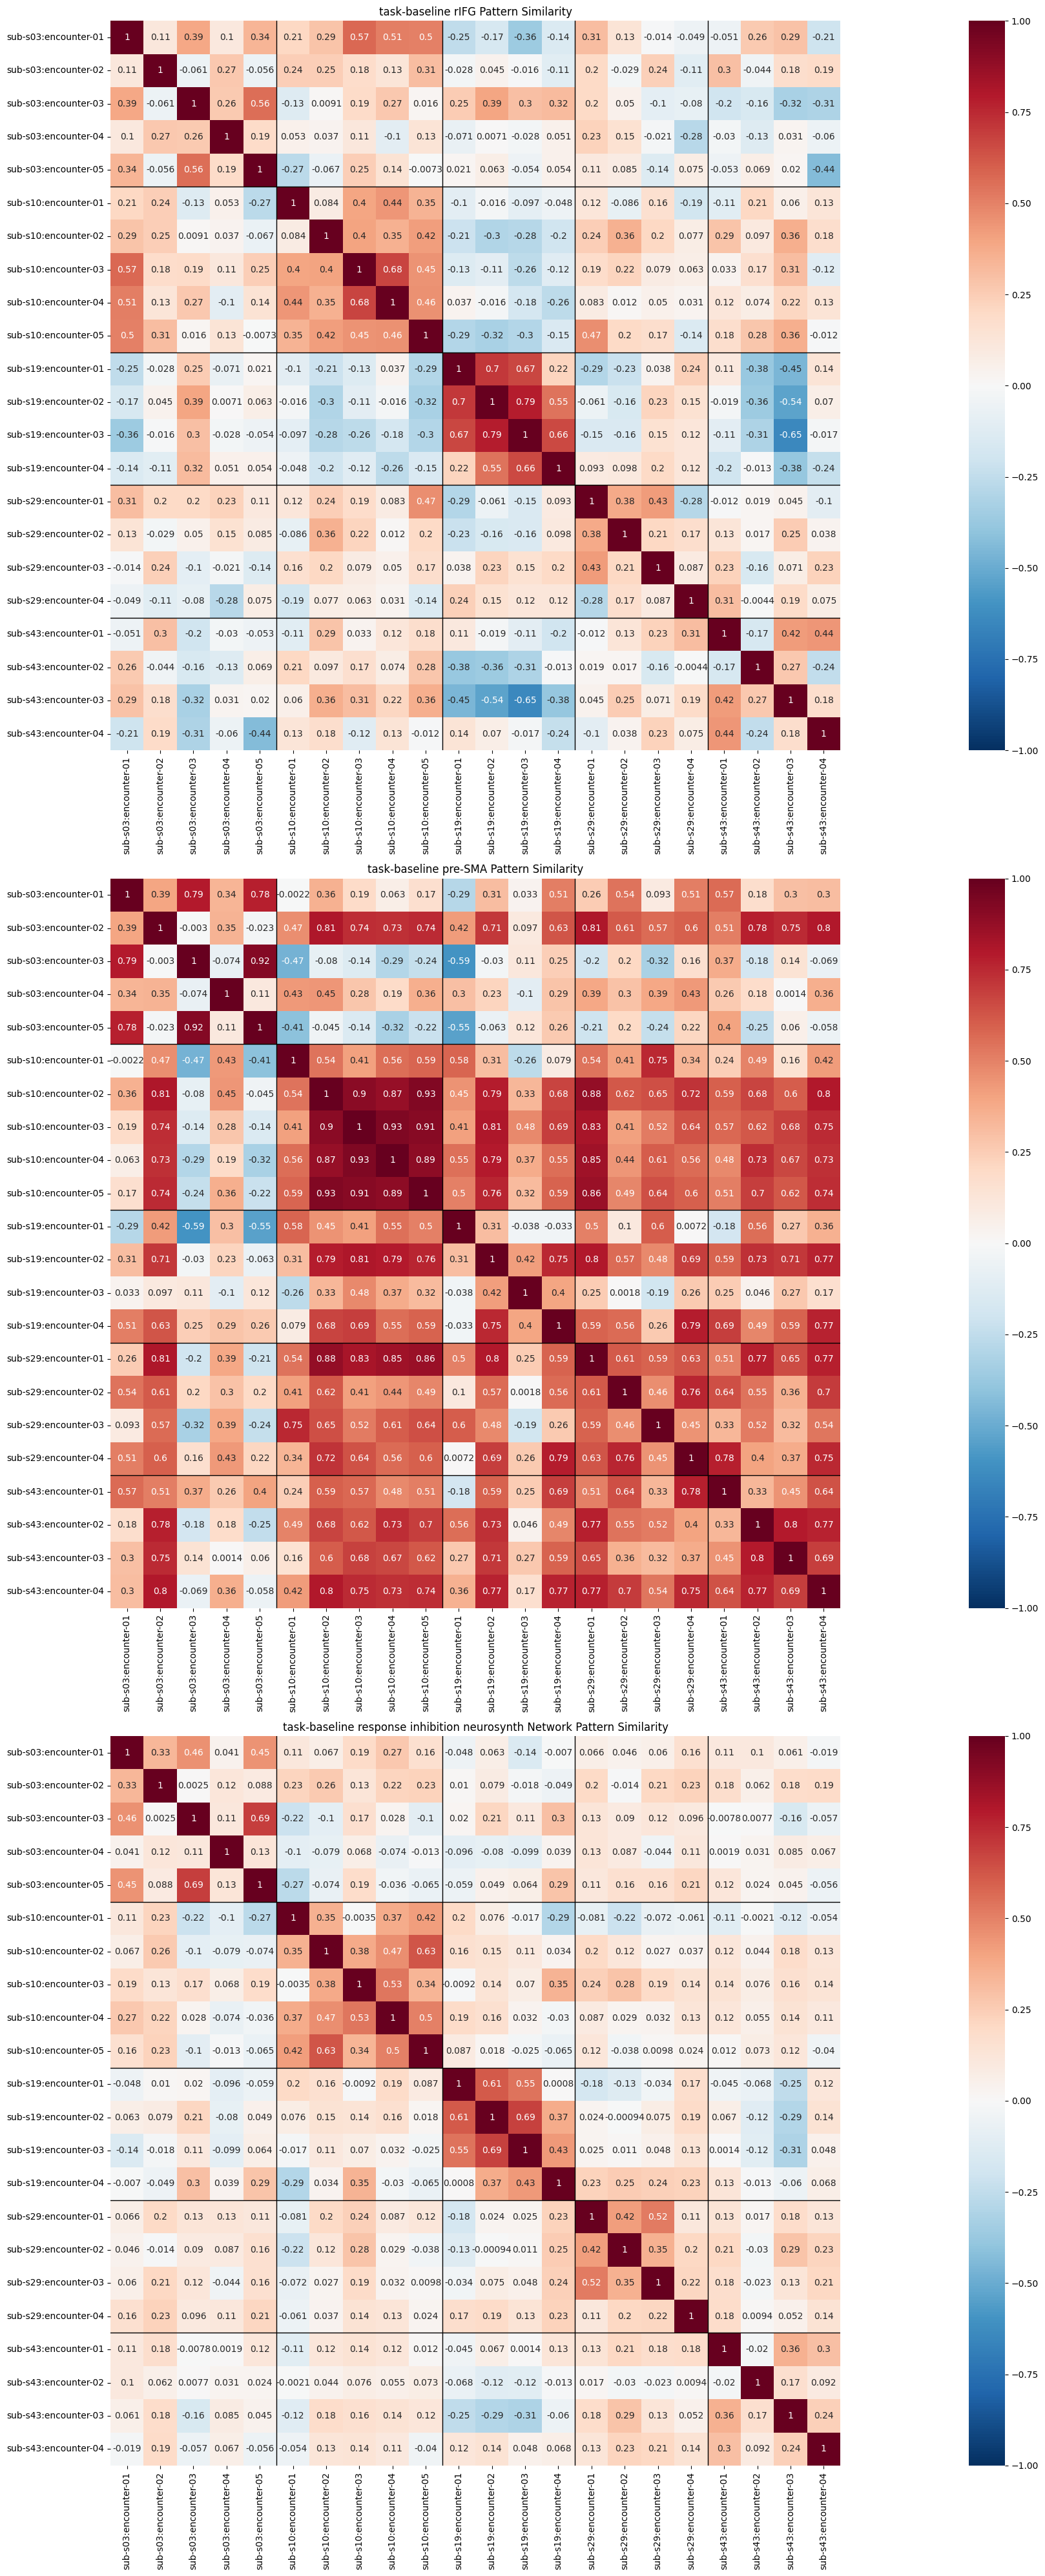

In [16]:
# plot the same for task-baseline
fig, axes = plt.subplots(3, 1, figsize=(40, 40))

# mask upper triangle
mask_upper_tri = np.tril(np.ones_like(condition_rifg_results["nogo_success-go rifg"]['rsm'],dtype=bool),k=-1)

# rIFG RSM
sns.heatmap(tb_rifg_results["tb rifg"]['rsm'], ax=axes[0], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           vmin=-1,      # Set minimum to -1
               vmax=1,)      # Set maximum to 1)
axes[0].set_title('task-baseline rIFG Pattern Similarity')
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[0].axhline(line_pos, color='black', linewidth=1)
        axes[0].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[0].axhline(line_pos, color='black', linewidth=1)
        axes[0].axvline(line_pos, color='black', linewidth=1)
        
# pre-SMA RSM  
sns.heatmap(tb_presma_results["tb pre-sma"]['rsm'], ax=axes[1], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           vmin=-1,      # Set minimum to -1
               vmax=1)       # Set maximum to 1)
axes[1].set_title('task-baseline pre-SMA Pattern Similarity')
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[1].axhline(line_pos, color='black', linewidth=1)
        axes[1].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[1].axhline(line_pos, color='black', linewidth=1)
        axes[1].axvline(line_pos, color='black', linewidth=1)

# Combined RSM
sns.heatmap(tb_combined_results["tb all neurosynth response inhibition"]['rsm'], ax=axes[2], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task]['task-baseline']["descriptors_list"],
           vmin=-1,      # Set minimum to -1
               vmax=1)       # Set maximum to 1)
axes[2].set_title('task-baseline response inhibition neurosynth Network Pattern Similarity')
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    if (i>2):
        encounters_per_subject = 4
        line_pos = 2 * 5 + (i-2) * encounters_per_subject
        axes[2].axhline(line_pos, color='black', linewidth=1)
        axes[2].axvline(line_pos, color='black', linewidth=1)
    else:
        line_pos = i * encounters_per_subject
        axes[2].axhline(line_pos, color='black', linewidth=1)
        axes[2].axvline(line_pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()

### visualizing changes in spatial similarity across encounters

In [17]:
# for each region, go to the task/contrast and save the correlations for enc 0, enc 1, enc 2, etc to a list each
gng_regions = ['rifg','pre-sma','all neurosynth']
gng_tasks = [curr_task]
gng_contrasts = ['nogo_success-go','task-baseline']

all_rsms = {curr_task: {
            'task-baseline':
                        {'rifg':tb_rifg_results['tb rifg'],
                         'pre-sma':tb_presma_results['tb pre-sma'],
                         'all neurosynth':tb_combined_results["tb all neurosynth response inhibition"]},
            'nogo_success-go':
                        {'rifg':condition_rifg_results['nogo_success-go rifg'],
                         'pre-sma':condition_presma_results['nogo_success-go pre-sma'],
                         'all neurosynth':condition_combined_results["nogo_success-go all neurosynth response inhibition"]}
           }}

In [18]:
encounter_specific_corrs = {}
for region in gng_regions:
    encounter_specific_corrs[region] = {}

    for task in gng_tasks:
        encounter_specific_corrs[region][task] = {}

        for contrast in gng_contrasts:
            encounter_specific_corrs[region][task][contrast] = {"1":[], "2":[], "3":[], "4":[], "5":[]}

            try:
                rsm_data = all_rsms[task][contrast][region]
                # Use rsm_data
            
            except KeyError as e:
                # Handle missing key
                print(f"Key not found: {e} so continuing")
                continue
        
            rsm_data = all_rsms[task][contrast][region]
            rsm_matrix = rsm_data['rsm']
            descriptors = rsm_data['descriptors']

            # label the data with which encounter each map belongs to
            encounter_map_indices = {}  # encounter_id -> [map indices]
            
            for i, desc in enumerate(descriptors):
                # format: descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                encounter_id = desc.split('encounter-0')[1]
                
                if encounter_id not in encounter_map_indices:
                    encounter_map_indices[encounter_id] = []
                
                encounter_map_indices[encounter_id].append(i)
        
            upper_tri = np.triu_indices_from(rsm_matrix, k=1)
            all_correlations = rsm_matrix[upper_tri]
                        
            for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                # Find which encounters these two maps belong to
                enc_for_map_row = None
                enc_for_map_col = None
                
                for encounter_id, map_indices in encounter_map_indices.items():
                    if row in map_indices:
                        enc_for_map_row = encounter_id
                    if col in map_indices:
                        enc_for_map_col = encounter_id
                        
                # get the corr
                correlation_value = all_correlations[idx]
        
                # put the corr into assigned group
                # only include if its the same encounter both ways 
                if enc_for_map_row == enc_for_map_col:
                    # Same encounter
                    encounter_specific_corrs[region][task][contrast][enc_for_map_row].append(correlation_value)                    
                    

In [19]:
# Calculate mean between-subject correlation for each encounter (same as before)
encounter_means = {}
for region in gng_regions:
    encounter_means[region] = {}
    for task in gng_tasks:
        encounter_means[region][task] = {}
        for contrast in gng_contrasts:
            encounter_means[region][task][contrast] = {}
            for encounter in ["1", "2", "3", "4", "5"]:
                corrs = encounter_specific_corrs[region][task][contrast][encounter]
                if corrs:
                    encounter_means[region][task][contrast][encounter] = np.mean(corrs)
                else:
                    encounter_means[region][task][contrast][encounter] = np.nan

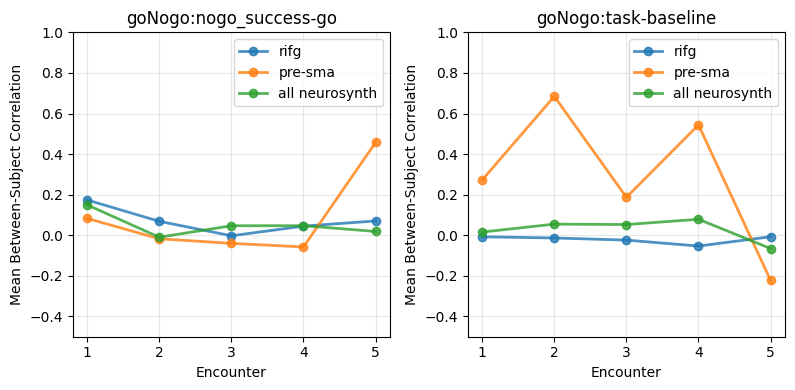

In [20]:
# plot change over time, only for regions of interest and requested_task_contrasts
tasks_contrasts = [(task, contrast) for task in gng_tasks 
                   for contrast in gng_contrasts]

num_plots = len(tasks_contrasts)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# single row case
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (task, contrast) in enumerate(tasks_contrasts):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    encounters = ["1", "2", "3", "4", "5"]
    
    # Plot each region as a separate line
    for region in gng_regions:
        means = [encounter_means[region][task][contrast][enc] for enc in encounters]
        ax.plot(encounters, means, 'o-', linewidth=2, markersize=6, 
               label=region, alpha=0.8)
    
    ax.set_xlabel('Encounter')
    ax.set_ylabel('Mean Between-Subject Correlation')
    ax.set_title(f'{task}:{contrast}')
    ax.set_ylim(-0.5, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_plots, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
# For each subject, track correlations between different encounters
within_subj_cross_encounter_vals = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for subj in SUBJECTS:
    for region in gng_regions:
        for task in gng_tasks:
            for contrast in gng_contrasts:

                try:
                    rsm_data = all_rsms[task][contrast][region]
                    # Use rsm_data
                
                except KeyError as e:
                    # Handle missing key
                    print(f"Key not found: {e} so continuing")
                    continue

                rsm_matrix = rsm_data['rsm']
                descriptors = rsm_data['descriptors']
                
                # Map indices to encounters for this subject only
                encounter_map_indices = defaultdict(list)
                
                for i, desc in enumerate(descriptors):
                    subject_id = desc.split(':')[0]
                    if subject_id == subj:  # Only process maps for current subject
                        encounter_id = desc.split('encounter-0')[1]
                        encounter_map_indices[encounter_id].append(i)
                
                # Get correlations between different encounters
                upper_tri = np.triu_indices_from(rsm_matrix, k=0)
                
                for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                    # Find encounters for these maps
                    enc_row = None
                    enc_col = None
                    
                    for encounter_id, map_indices in encounter_map_indices.items():
                        if row in map_indices:
                            enc_row = encounter_id
                        if col in map_indices:
                            enc_col = encounter_id
                    
                    # Only include if both maps are from current subject
                    if enc_row and enc_col:
                        if enc_row == enc_col:
                            correlation_value = 1.0
                        else:
                            correlation_value = rsm_matrix[row, col]
                        
                        # Store bidirectionally (1->2 and 2->1)
                        within_subj_cross_encounter_vals[subj][task][contrast][region][f"{enc_row}_{enc_col}"].append(correlation_value)                                        
                        # Record the reverse pair 
                        within_subj_cross_encounter_vals[subj][task][contrast][region][f"{enc_col}_{enc_row}"].append(correlation_value)


In [33]:
line_input_gng = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for task in gng_tasks:
    for contrast in gng_contrasts:
        for region in gng_regions:
            for i in range(max_num_encounters):
                for j in range(max_num_encounters):
                    line_input_gng[task][contrast][region][i][j] = []
            
            # Collect data for each encounter pair
            for i in range(max_num_encounters):
                for j in range(max_num_encounters):
                    enc_name = f"{i+1}_{j+1}"
                    
                    # Collect correlations from all subjects for this encounter pair
                    for subj in SUBJECTS:
                        if enc_name in within_subj_cross_encounter_vals[subj][task][contrast][region]:
                            subj_correlations = within_subj_cross_encounter_vals[subj][task][contrast][region][enc_name]
                            if subj_correlations:  # Only add if there are actual values
                                line_input_gng[task][contrast][region][i][j].extend(subj_correlations)
            
            # Convert to means after collecting all subject data
            for i in range(max_num_encounters):
                for j in range(max_num_encounters):
                    all_correlations = line_input_gng[task][contrast][region][i][j]
                    if all_correlations:  # Only compute mean if there are values
                        line_input_gng[task][contrast][region][i][j] = np.mean(all_correlations)
                    else:
                        line_input_gng[task][contrast][region][i][j] = np.nan  # Use NaN for missing data

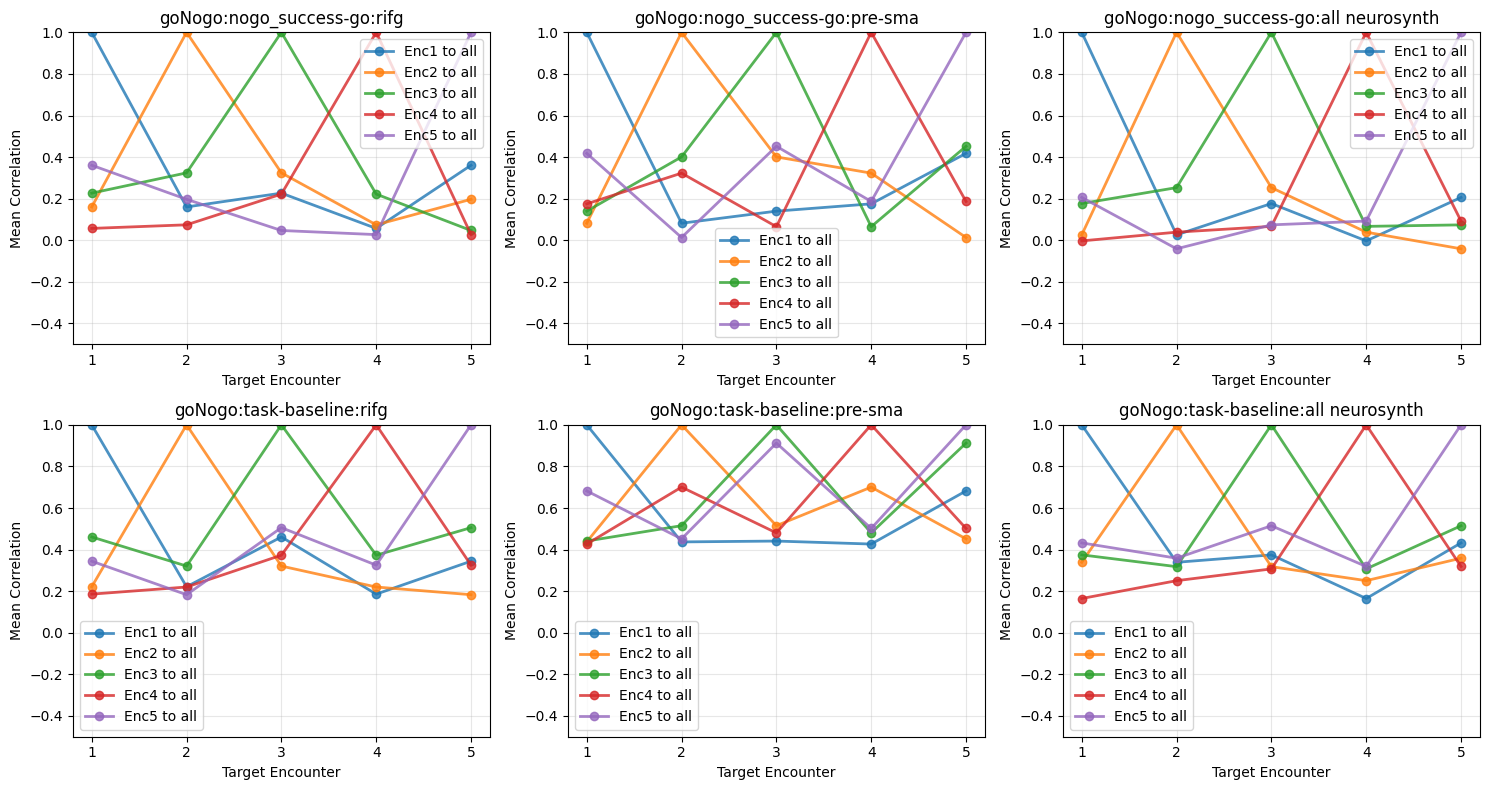

In [37]:
# Create separate plots for each task/contrast/region combination
task_contrast_region_combos = [(task, contrast, region) for task in gng_tasks 
                               for contrast in gng_contrasts 
                               for region in gng_regions]

num_plots = len(task_contrast_region_combos)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

# Handle single plot case
if num_plots == 1:
    axes = [axes]
# Handle single row case
elif num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (task, contrast, region) in enumerate(task_contrast_region_combos):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    encounters = ["1", "2", "3", "4", "5"]
    
    # For each encounter (1-5), plot its correlation with all encounters
    for enc in range(5):  # This is the "from" encounter (1, 2, 3, 4, 5)
        
        # Get correlations from this encounter to all encounters
        correlations_to_all = []
        for target_enc in range(5):  # This is the "to" encounter
            correlation = line_input_gng[task][contrast][region][enc][target_enc]
            correlations_to_all.append(correlation)
        
        # Plot the line showing how encounter (enc+1) correlates with all encounters
        ax.plot(encounters, correlations_to_all, 'o-', linewidth=2, markersize=6, 
               label=f"Enc{enc+1} to all", alpha=0.8)
    
    ax.set_xlabel('Target Encounter')
    ax.set_ylabel('Mean Correlation')
    ax.set_title(f'{task}:{contrast}:{region}')
    ax.set_ylim(-0.5, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_plots, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    if num_rows > 1:
        axes[row, col].set_visible(False)
    else:
        axes[col].set_visible(False)

plt.tight_layout()
plt.show()

Creating summary comparison...


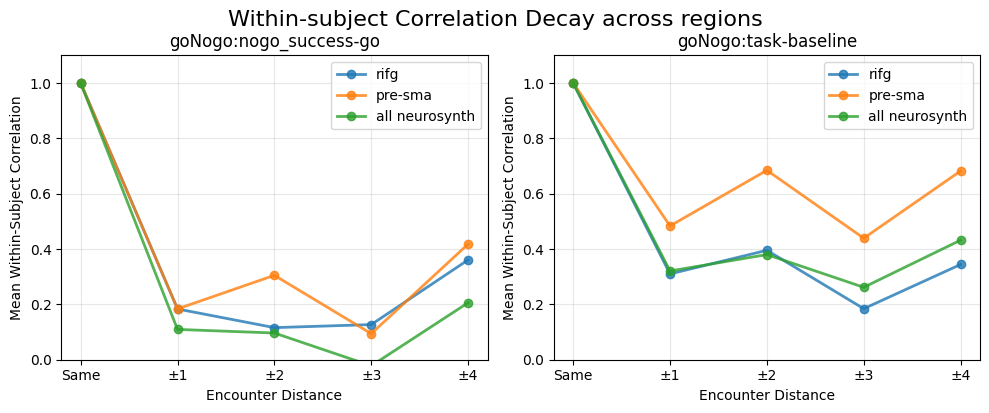

In [42]:
def create_summary_comparison(line_input_gng, gng_tasks, gng_contrasts, gng_regions):
    """
    Comparing regions side-by-side
    """
    fig, axes = plt.subplots(len(gng_tasks), len(gng_contrasts), 
                            figsize=(5*len(gng_contrasts), 4*len(gng_tasks)))
    
    if len(gng_tasks) == 1 and len(gng_contrasts) == 1:
        axes = [[axes]]
    elif len(gng_tasks) == 1:
        axes = [axes]
    elif len(gng_contrasts) == 1:
        axes = [[ax] for ax in axes]
    
    for task_idx, task in enumerate(gng_tasks):
        for contrast_idx, contrast in enumerate(gng_contrasts):
            ax = axes[task_idx][contrast_idx]
            
            # Calculate decay for each region
            distances = [0, 1, 2, 3, 4]
            
            for region in gng_regions:
                correlations_by_distance = {d: [] for d in distances}
                
                for i in range(5):
                    for j in range(5):
                        distance = abs(i - j)
                        corr_val = line_input_gng[task][contrast][region][i][j]
                        if not np.isnan(corr_val):
                            correlations_by_distance[distance].append(corr_val)
                
                mean_corrs = []
                for d in distances:
                    if correlations_by_distance[d]:
                        mean_corrs.append(np.mean(correlations_by_distance[d]))
                    else:
                        mean_corrs.append(np.nan)
                
                ax.plot(distances, mean_corrs, marker='o', linewidth=2, 
                       markersize=6, label=region, alpha=0.8)
            
            ax.set_xlabel('Encounter Distance')
            ax.set_ylabel('Mean Within-Subject Correlation')
            ax.set_title(f'{task}:{contrast}')
            ax.set_ylim(0, 1.1)
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xticks(distances)
            ax.set_xticklabels(['Same', '±1', '±2', '±3', '±4'])
    
    plt.tight_layout()
    plt.suptitle('Within-subject Correlation Decay across regions', y=1.02, fontsize=16)
    return fig


print("Creating summary comparison...")
fig3 = create_summary_comparison(line_input_gng, gng_tasks, gng_contrasts, gng_regions)
plt.show()

# flanker

In [30]:
# get the go  no go specific data paths and load them all
curr_task = "flanker"

task_contrast_all_maps = {}
not_included = {}
print("MISSING:") # to see what maps are missing

task_contrast_all_maps[curr_task] = {}
for contrast in requested_task_contrasts[curr_task]:
    task_contrast_all_maps[curr_task][contrast] = {}
    task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
    task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
    task_contrast_all_maps[curr_task][contrast]["data_title"] = ""

    req_tasks = [curr_task]
    req_contrasts = [contrast]

    task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks,req_contrasts,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)
    

MISSING:


In [31]:
# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

incongruent-congruent: 25 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 25 maps loaded
  Map shape: (97, 115, 97)


## neurosynth: inhibitory control

### loading the data per subject per encounter and masking it

Data range: 0.00 to 7.10
Non-zero values range: 4.42 to 7.10


/tmp/ipykernel_21019/1609399822.py:13: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  neurosynth_mask = image.threshold_img(neurosynth_inhibitory_control_map, threshold=threshold)
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/image.py:1245: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img=threshold_img(


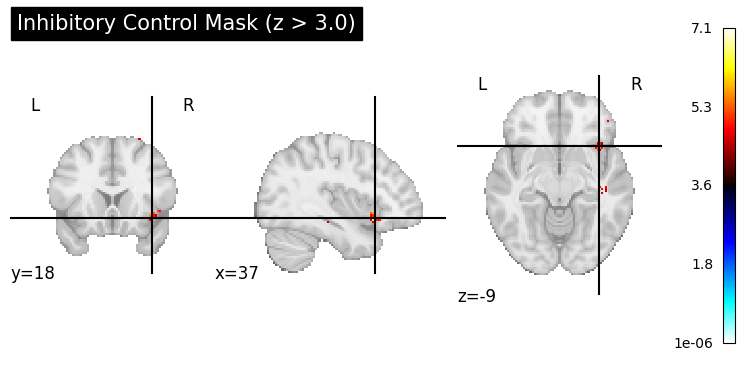

In [53]:
# load the "response inhibition" results from neurosynth
neurosynth_inhibitory_control_map = nib.load('./neurosynth_rois/inhibitory_control_association-test_z_FDR_0.01.nii')

# Check the data range to choose appropriate threshold
data = neurosynth_inhibitory_control_map.get_fdata()
print(f"Data range: {data.min():.2f} to {data.max():.2f}")
print(f"Non-zero values range: {data[data>0].min():.2f} to {data[data>0].max():.2f}")

# pick areas of activation to use
threshold = 3.0  # pretty liberal

# create the mask + binarize it
neurosynth_mask = image.threshold_img(neurosynth_inhibitory_control_map, threshold=threshold)
neurosynth_binary = image.binarize_img(neurosynth_mask)

# Visualize to see what you're getting
plotting.plot_stat_map(neurosynth_mask, 
                      title=f'Inhibitory Control Mask (z > {threshold})')#rifg and Anterior cingulate/medial frontal areas
plotting.show() # shows the right ifg in the x plot, and the pre sma in the z plot

In [54]:
# get the gonogo data for the main condition and task-baseline
ic_condition_maps = task_contrast_all_maps[curr_task]["incongruent-congruent"]["maps_list"]
ic_tb_maps = task_contrast_all_maps[curr_task]["task-baseline"]["maps_list"]

# resample neurosynth map so it's same size
print("Neurosynth binary shape:", neurosynth_binary.shape)
sample_map = ic_condition_maps[0]
print("data shape:", sample_map.shape)
neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
print("Resampled neurosynth binary shape:", neurosynth_resampled.shape)

Neurosynth binary shape: (91, 109, 91)
data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)


/tmp/ipykernel_21019/1742140535.py:9: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [55]:
# Get the affine and shape from the resampled neurosynth map
affine = neurosynth_resampled.affine
shape = neurosynth_resampled.shape
# Create coordinate grids
coords = np.array(np.meshgrid(
    np.arange(shape[0]),
    np.arange(shape[1]), 
    np.arange(shape[2]),
    indexing='ij'))
# Convert voxel coordinates to MNI coordinates
coords_flat = coords.reshape(3, -1)
mni_coords = nib.affines.apply_affine(affine, coords_flat.T).T
x_mni = mni_coords[0].reshape(shape)
y_mni = mni_coords[1].reshape(shape) 
z_mni = mni_coords[2].reshape(shape)

# Get neurosynth mask data; use this as a full mask this time
mask_data = neurosynth_resampled.get_fdata()
combined_data = mask_data > 0
combined_mask = image.new_img_like(neurosynth_resampled, combined_data.astype(np.int32))

# Check how many voxels are in each mask
print(f"Combined mask: {np.sum(combined_mask.get_fdata() > 0)} voxels")

Combined mask: 226 voxels


In [56]:
# Mask the main condition flanker data
combined_values_condition = []

for map_obj in ic_condition_maps:
    map_array = map_obj.get_fdata()
    
    combined_values_condition.append(map_array[combined_mask.get_fdata().astype(bool)])

print(f"Extracted {len(combined_values_condition)} values for each ROI for nogo_success-go") 

# Mask the task-baseline flanker data
combined_values_tb = []

for map_obj in ic_tb_maps:
    map_array = map_obj.get_fdata()

    combined_values_tb.append(map_array[combined_mask.get_fdata().astype(bool)])

print(f"Extracted {len(rifg_values_tb)} values for each ROI in task-baseline") 

Extracted 25 values for each ROI for nogo_success-go
Extracted 22 values for each ROI in task-baseline


### visualizing how spatial activation changes over encounters in each of the regions (rIFG and pre-sma, as well as in them together)

In [57]:
# Get the spatial pattern rsms for the main condition and task-baseline
main_condition = 'incongruent-congruent'
tb = 'task-baseline'
neurosynth_template = 'inhibitory control'
condition_combined_results,_ = compute_rsms(
    combined_values_condition, 
    task_contrast_all_maps[curr_task][main_condition]["descriptors_list"],
    f"{main_condition} all neurosynth {neurosynth_template}"
)

tb_combined_results,_ = compute_rsms(
    combined_values_tb, 
    task_contrast_all_maps[curr_task][tb]["descriptors_list"],
    f"{tb} all neurosynth {neurosynth_template}"
)

Computing RSM for 25 maps using pearson correlation
Successfully computed pattern-based RSMs for incongruent-congruent all neurosynth inhibitory control
Computing RSM for 25 maps using pearson correlation
Successfully computed pattern-based RSMs for task-baseline all neurosynth inhibitory control


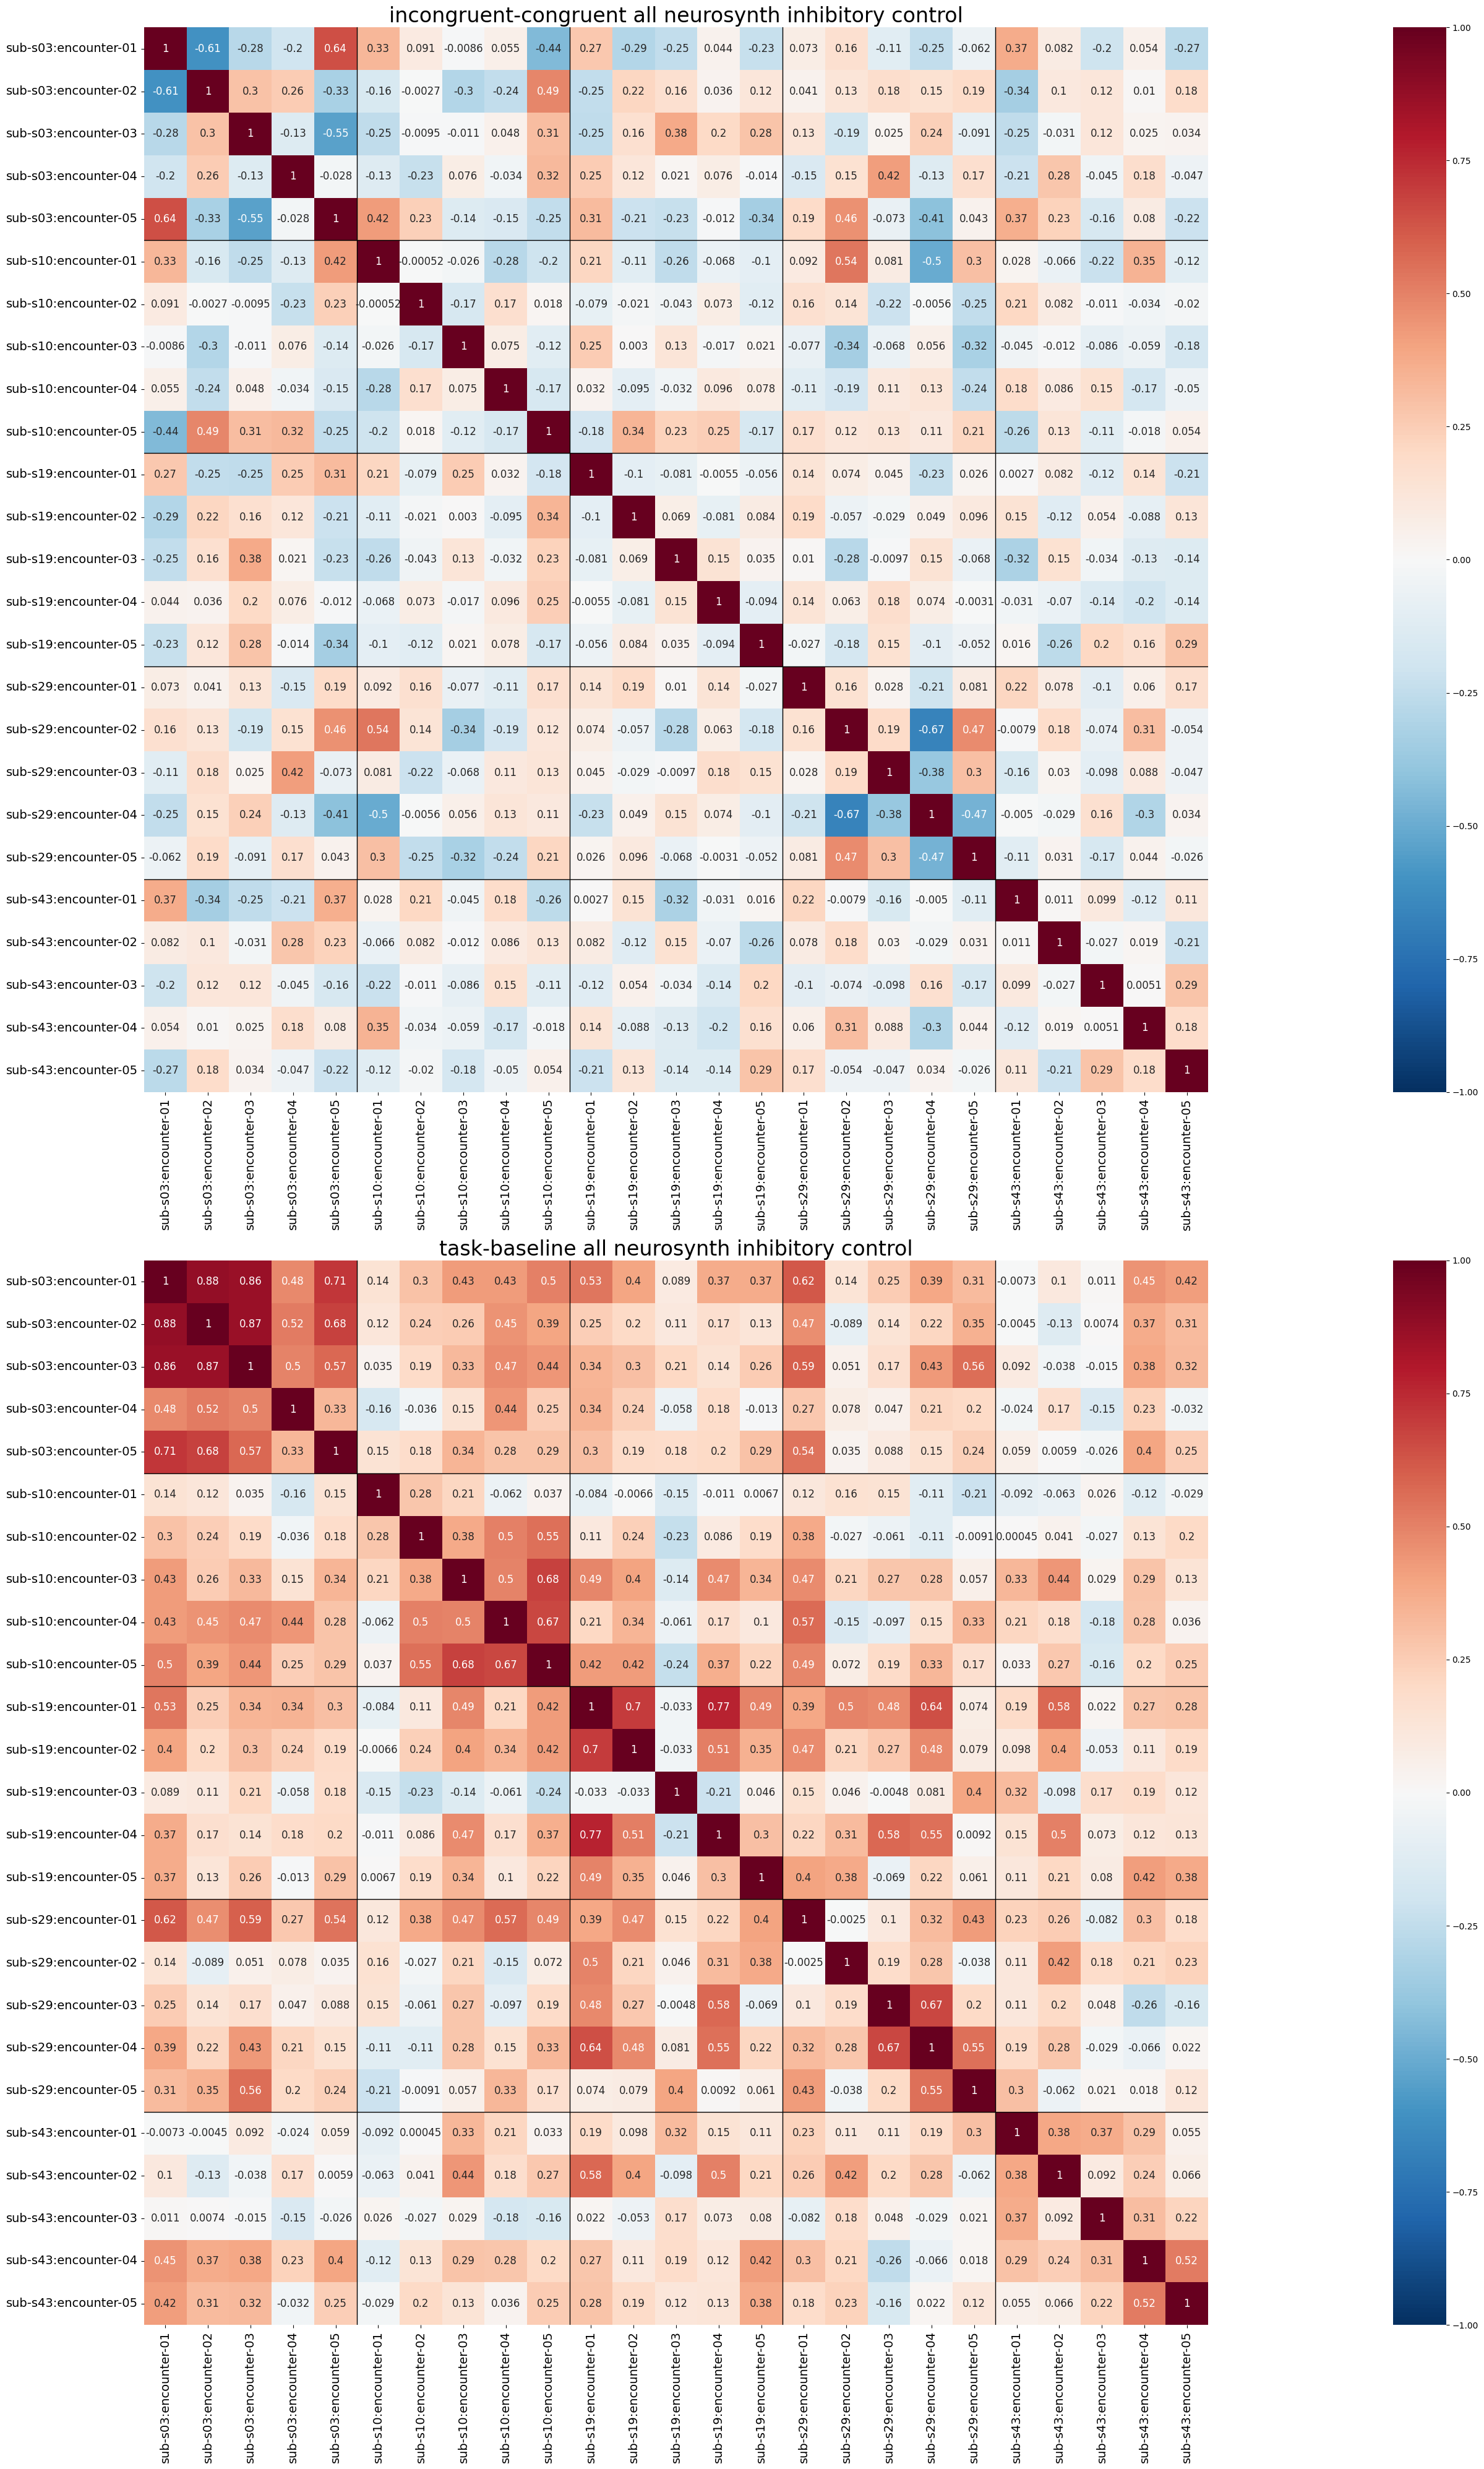

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(60, 40))

# plot the main condition and the task-baseline

# mask upper triangle
mask_upper_tri = np.tril(np.ones_like(condition_combined_results[f"{main_condition} all neurosynth {neurosynth_template}"]['rsm'],dtype=bool),k=-1)

# Combined RSM
# main condition
sns.heatmap(condition_combined_results[f"{main_condition} all neurosynth {neurosynth_template}"]['rsm'], ax=axes[0], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task][main_condition]["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task][main_condition]["descriptors_list"],
            vmin=-1,      # Set minimum to -1
               vmax=1,       # Set maximum to 1
            annot_kws={'size': 12},
           # mask=mask_upper_tri
           )
axes[0].set_title(f"{main_condition} all neurosynth {neurosynth_template}", fontsize = 24)
axes[0].tick_params(axis='both', which='major', labelsize=14)
encounters_per_subject = 5
n_subjects = len(SUBJECTS)
for i in range(1, n_subjects):
    line_pos = i * encounters_per_subject
    axes[0].axhline(line_pos, color='black', linewidth=1)
    axes[0].axvline(line_pos, color='black', linewidth=1)

# task-baseline
sns.heatmap(tb_combined_results[f"{tb} all neurosynth {neurosynth_template}"]['rsm'], ax=axes[1], annot=True, cmap='RdBu_r', center=0, square=True,
           xticklabels=task_contrast_all_maps[curr_task][tb]["descriptors_list"],
           yticklabels=task_contrast_all_maps[curr_task][tb]["descriptors_list"],
            vmin=-1,      # Set minimum to -1
               vmax=1,       # Set maximum to 1
            annot_kws={'size': 12},
           # mask=mask_upper_tri
           )
axes[1].set_title(f"{tb} all neurosynth {neurosynth_template}", fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=14)
for i in range(1, n_subjects):
    line_pos = i * encounters_per_subject
    axes[1].axhline(line_pos, color='black', linewidth=1)
    axes[1].axvline(line_pos, color='black', linewidth=1)
    
plt.tight_layout()
plt.savefig('flanker_rsm_heatmaps.pdf', bbox_inches='tight')  # Vector format
plt.show()


### visualizing changes in spatial similarity across encounters

In [72]:
# for each region, go to the task/contrast and save the correlations for enc 0, enc 1, enc 2, etc to a list each
tasks = [curr_task]
contrasts = [main_condition,tb]
regions = [f'all neurosynth {neurosynth_template}']

all_rsms = {curr_task: {
            tb:
                        {f'all neurosynth {neurosynth_template}':tb_combined_results[f"{tb} all neurosynth {neurosynth_template}"]},
            main_condition:
                        {f'all neurosynth {neurosynth_template}':condition_combined_results[f"{main_condition} all neurosynth {neurosynth_template}"]}
           }}

print(tasks)

['flanker']


In [73]:
encounter_specific_corrs = {}
curr_region = f'all neurosynth {neurosynth_template}'

for region in regions:
    encounter_specific_corrs[region] = {}
    
    for task in tasks:
        print(task)
        encounter_specific_corrs[region][task] = {}
    
        for contrast in contrasts:
            encounter_specific_corrs[region][task][contrast] = {"1":[], "2":[], "3":[], "4":[], "5":[]}
    
            try:
                print(contrast)
                rsm_data = all_rsms[task][contrast][region]
                # Use rsm_data
            
            except KeyError as e:
                # Handle missing key
                print(f"Key not found: {e} so continuing")
                continue
        
            rsm_matrix = rsm_data['rsm']
            descriptors = rsm_data['descriptors']
    
            # label the data with which encounter each map belongs to
            encounter_map_indices = {}  # encounter_id -> [map indices]
            
            for i, desc in enumerate(descriptors):
                # format: descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                encounter_id = desc.split('encounter-0')[1]
                
                if encounter_id not in encounter_map_indices:
                    encounter_map_indices[encounter_id] = []
                
                encounter_map_indices[encounter_id].append(i)
        
            upper_tri = np.triu_indices_from(rsm_matrix, k=1)
            all_correlations = rsm_matrix[upper_tri]
                        
            for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                # Find which encounters these two maps belong to
                enc_for_map_row = None
                enc_for_map_col = None
                
                for encounter_id, map_indices in encounter_map_indices.items():
                    if row in map_indices:
                        enc_for_map_row = encounter_id
                    if col in map_indices:
                        enc_for_map_col = encounter_id
                        
                # get the corr
                correlation_value = all_correlations[idx]
        
                # put the corr into assigned group
                # only include if its the same encounter both ways 
                if enc_for_map_row == enc_for_map_col:
                    # Same encounter
                    encounter_specific_corrs[region][task][contrast][enc_for_map_row].append(correlation_value)                    
                    

flanker
incongruent-congruent
task-baseline


In [76]:
# Calculate mean between-subject correlation for each encounter (same as before)
encounter_means = {}
for region in regions:
    encounter_means[region] = {}
    for task in tasks:
        encounter_means[region][task] = {}
        for contrast in contrasts:
            encounter_means[region][task][contrast] = {}
            for encounter in ["1", "2", "3", "4", "5"]:
                corrs = encounter_specific_corrs[region][task][contrast][encounter]
                if corrs:
                    encounter_means[region][task][contrast][encounter] = np.mean(corrs)
                else:
                    encounter_means[region][task][contrast][encounter] = np.nan

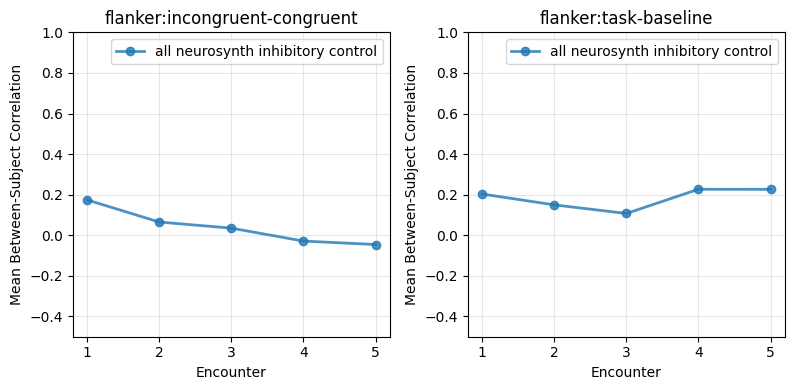

In [82]:
# plot change over time, only for regions of interest and requested_task_contrasts
tasks_contrasts = [(task, contrast) for task in tasks 
                   for contrast in contrasts]

num_plots = len(tasks_contrasts)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# single row case
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (task, contrast) in enumerate(tasks_contrasts):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    encounters = ["1", "2", "3", "4", "5"]
    
    # Plot each region as a separate line
    for region in regions:
        means = [encounter_means[region][task][contrast][enc] for enc in encounters]
        ax.plot(encounters, means, 'o-', linewidth=2, markersize=6, 
               label=region, alpha=0.8)
    
    ax.set_xlabel('Encounter')
    ax.set_ylabel('Mean Between-Subject Correlation')
    ax.set_title(f'{task}:{contrast}')
    ax.set_ylim(-0.5, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_plots, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()


# make same plot but within subj somehow??